## Warmstart + Noise Backend + Optuna (IBM)

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))

In [2]:
import qiskit
qiskit.IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
import optuna
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer, SlsqpOptimizer, CobylaOptimizer, MinimumEigenOptimizer
from qiskit.algorithms import QAOA

from shared.QiskitMaxcut import *
from ibm.ibm_parameters import *

%matplotlib inline

In [4]:
print_parameters()

Optimizers: ['COBYLA'] with MaxIter of 1
Number of shots: 8000
Repetitions: [ 1; 1 ]
Gamma value interval: [ -3.141592653589793; 3.141592653589793 ]
Beta value interval: [ 3.141592653589793;-3.141592653589793 ]
Number of Optuna Trials: 1
Noise Backend Name: ibmq_toronto


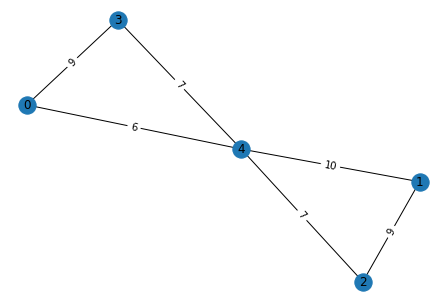

In [5]:
# ---- Define graph and MaxCut ----
graph = load_graph()
max_cut = Maxcut(graph)
max_cut_qubo = max_cut.to_qubo()
max_cut.draw()

In [6]:
def init_qaoa(optimizer, reps, init_parameters):

    quantum_instance = QuantumInstance( backend=Aer.get_backend(DEFAULT_QASM_SIMULATOR),
                                        shots=SHOTS,
                                        noise_model=noise_model,
                                        coupling_map=coupling_map,
                                        basis_gates=basis_gates,
                                      )

    if optimizer == "QN-SPSA":
        # generate QAOA to get ansatz
        pre_qaoa = QAOA(optimizer=COBYLA(maxiter=1, tol=0), quantum_instance=quantum_instance, reps=reps, initial_point=init_parameters)
        MinimumEigenOptimizer(pre_qaoa).solve(max_cut_qubo)
        fidelity = QNSPSA.get_fidelity(pre_qaoa.ansatz)
        optimizer = QNSPSA(fidelity, maxiter=MAX_ITER)

    qaoa = QAOA(optimizer=optimizer, 
                quantum_instance=quantum_instance, 
                reps=reps,
                initial_point=init_parameters) 

    ws_qaoa = WarmStartQAOAOptimizer(pre_solver=SlsqpOptimizer(),
                                     relax_for_pre_solver=True,
                                     qaoa=qaoa)

    return ws_qaoa

In [7]:
def run(max_cut_problem, qaoa):
    # Run quantum algorithm QAOA
    result = qaoa.solve(max_cut_problem)
    optimal_parameters = qaoa._qaoa.optimal_params
    return result, optimal_parameters.copy()

In [8]:
def objective(trial):
    optimizer_name = trial.suggest_categorical("optimizer", optimizers.keys())
    reps = trial.suggest_int('reps', REPS_MIN, REPS_MAX + 1)
    parameters = []
    for i in range(reps):
        parameters.append(trial.suggest_uniform(f'gamma_{i}', GAMMA_MIN, GAMMA_MAX))

    for i in range(reps):
        parameters.append(trial.suggest_uniform(f'beta_{i}', BETA_MIN, BETA_MAX))

    optimizer = optimizers[optimizer_name]
        
    qaoa = init_qaoa(optimizer, reps, parameters)
    
    result, optimal_parameters = run(max_cut_qubo, qaoa)
    
    mean, distribution = max_cut.analyse(result)
    trial.set_user_attr(key="best", value=[mean,result,optimal_parameters, optimizer_name])
    
    return mean

In [9]:
# Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS, callbacks=[save_best_trial])


[I 2021-08-05 10:23:57,552] A new study created in memory with name: no-name-a673e7ca-58cb-4ecd-9f5f-5a197657bf70
/var/folders/fn/1fd59zzx3yv9s4hv8s5hrlw00000gn/T/ipykernel_41247/4269834728.py:4: DeprecationWarning: 
The VQE.optimal_params property is deprecated as of Qiskit Terra 0.18.0
and will be removed no sooner than 3 months after the releasedate.
This information is part of the returned result object and can be
queried as VQEResult.optimal_point.
  optimal_parameters = qaoa._qaoa.optimal_params
[I 2021-08-05 10:23:59,054] Trial 0 finished with value: -24.865 and parameters: {'optimizer': 'COBYLA', 'reps': 2, 'gamma_0': -0.9764166844059483, 'gamma_1': 2.3555384980408753, 'beta_0': -0.9629296626859798, 'beta_1': 1.4452124904969503}. Best is trial 0 with value: -24.865.


ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
print(study.best_trial)

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
mean, result, optimal_params, optimizer_name = study.user_attrs["best"]
print(f"Optimizer: {optimizer_name}")
print(f"Optimal Parameters: {optimal_params}")

In [ ]:
max_cut.draw(result)

In [ ]:
mean, distribution = max_cut.analyse(result, print_output=True)
max_cut.plot_histogram(distribution, mean)

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table